# Battle of the Neighborhoods

I've chosen to investigate how to utilize machine learning techniques to recommend neighborhoods when relocating from one city to another. In this project I build a framework general enough to take any source city/list of neighborhoods and any destination city/list of neighborhoods, but I will be using the specific examples of Boston, MA, USA and Stockholm, Sweden. In specific, my spouse's favorite neighborhood in Boston is Davis Square, so I'm going to also answer the question of which neighborhood in Stockholm is most like Davis Square!

## FourSquare Credentials Stored in Hidden Cell

In [1]:
# @hidden_cell
CLIENT_ID = 'REDACTED' # your Foursquare ID
CLIENT_SECRET = 'REDACTED' # your Foursquare Secret
VERSION='20180605'

## Install and import necessary packages!

In [2]:
# Need to install this package
!pip3 install folium

     |████████████████████████████████| 94 kB 6.3 MB/s  eta 0:00:01


In [3]:
#import statements

#data analysis
import pandas as pd
import numpy as np

import json
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist 

import folium # map rendering library
from geopy.geocoders import Nominatim 

geolocator = Nominatim(user_agent='Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36')


print('Libraries imported.')

Libraries imported.


In [4]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_567643abaf684879ad540e4962d4093d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='REDACTED',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_567643abaf684879ad540e4962d4093d.get_object(Bucket='ibmdatascience-donotdelete-pr-kdzi19kbp0chbz',Key='stadsdelar.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

stockholm_neighborhoods = df_data_1

stockholm_neighborhoods['City'] = ['Stockholm, Sweden'] * len(df_data_1['Neighborhood'])

## Define useful functions to grab all the coordinates for a DataFrame and to map them!

In [5]:
def buildHoodDF(neighborhoods=None):
    df = pd.DataFrame()
    if (neighborhoods is None):
        raise ValueError('Need a df of neighborhoods!')
    lats = []
    lons = []
    for city, hood in list(zip(neighborhoods['City'],neighborhoods['Neighborhood'])):
        address = '{}, {}'.format(hood, city)
        #geolocator = Nominatim(user_agent='Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36')
        try: 
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
            print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
        except:
            latitude = np.nan
            longitude = np.nan
            print('Cannot get coords for {}'.format(address))
        lats.append(latitude)
        lons.append(longitude)

    df['City'] = neighborhoods['City']
    df['Neighborhood'] = neighborhoods['Neighborhood']
    df['Latitude'] = lats
    df['Longitude'] = lons
    
    df = df.dropna()
    
    return df

And a function to map a city's dataframe

In [6]:
def maplocationDF(city, df):
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    
    folmap = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(folmap)  
        
    return folmap

We'll use this function to grab coordinate info first for Stockholm...

In [7]:
df_stockholm = buildHoodDF(stockholm_neighborhoods)
print(df_stockholm.shape)
df_stockholm

The geograpical coordinate of Abrahamsberg, Stockholm, Sweden are 59.3364679, 17.9537633.
The geograpical coordinate of Alvik, Stockholm, Sweden are 59.3334008, 17.9822792.
The geograpical coordinate of Älvsjö, Stockholm, Sweden are 59.2758491, 18.0018895.
The geograpical coordinate of Aspudden, Stockholm, Sweden are 59.3064663, 18.0013731.
The geograpical coordinate of Axelsberg, Stockholm, Sweden are 59.3043246, 17.9744141.
The geograpical coordinate of Bagarmossen, Stockholm, Sweden are 59.2761858, 18.13134.
The geograpical coordinate of Bandhagen, Stockholm, Sweden are 59.2703049, 18.0495879.
Cannot get coords for Birkastaden, Stockholm, Sweden
The geograpical coordinate of Björkhagen, Stockholm, Sweden are 59.291204, 18.1154858.
The geograpical coordinate of Blackeberg, Stockholm, Sweden are 59.3484727, 17.8826992.
The geograpical coordinate of Bredäng, Stockholm, Sweden are 59.2947832, 17.9334371.
The geograpical coordinate of Bromsten, Stockholm, Sweden are 59.3828205, 17.915649

,City,Neighborhood,Latitude,Longitude
0,"Stockholm, Sweden",Abrahamsberg,59.336468,17.953763
1,"Stockholm, Sweden",Alvik,59.333401,17.982279
2,"Stockholm, Sweden",Älvsjö,59.275849,18.001890
3,"Stockholm, Sweden",Aspudden,59.306466,18.001373
4,"Stockholm, Sweden",Axelsberg,59.304325,17.974414
...,...,...,...,...
63,"Stockholm, Sweden",Svedmyra,59.277491,18.067128
64,"Stockholm, Sweden",Tallkrogen,59.271529,18.086059
65,"Stockholm, Sweden",Vårberg,59.275887,17.889953
66,"Stockholm, Sweden",Vasastan,59.341350,18.048947


And then map it.... 

In [8]:
maplocationDF('Stockholm, Sweden', df_stockholm)

And then for Boston....

In [9]:
body = client_567643abaf684879ad540e4962d4093d.get_object(Bucket='ibmdatascience-donotdelete-pr-kdzi19kbp0chbz',Key='bostonsquares.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body,quotechar='\'')
df_data_2.head()

boston_neighborhoods = df_data_2
boston_neighborhoods

df_boston = buildHoodDF(boston_neighborhoods)
print(df_boston.shape)
df_boston

Cannot get coords for Adams Square, Boston, MA
The geograpical coordinate of Boston City Hall Plaza, Boston, MA are 42.360400999999996, -71.05768162905511.
The geograpical coordinate of Bowdoin Square, Boston, MA are 42.3613939, -71.0621197.
The geograpical coordinate of Brigham Circle, Boston, MA are 42.3346084, -71.1036922.
The geograpical coordinate of Central Square, Boston, MA are 42.3750202, -71.0393784.
Cannot get coords for Chester Square, Boston, MA
The geograpical coordinate of Copley Square, Boston, MA are 42.349990149999996, -71.07643966570842.
The geograpical coordinate of Day Square, Boston, MA are 42.3792028, -71.0277879.
The geograpical coordinate of Dewey Square, Boston, MA are 42.3529841, -71.05555365348606.
The geograpical coordinate of Dock Square, Boston, MA are 42.3609326, -71.0549137.
The geograpical coordinate of Edward Everett Square, Boston, MA are 42.3201744, -71.06145089973862.
The geograpical coordinate of Franklin Square, Boston, MA are 42.33881495, -71.07

,City,Neighborhood,Latitude,Longitude
1,"Boston, MA",Boston City Hall Plaza,42.360401,-71.057682
2,"Boston, MA",Bowdoin Square,42.361394,-71.062120
3,"Boston, MA",Brigham Circle,42.334608,-71.103692
4,"Boston, MA",Central Square,42.375020,-71.039378
6,"Boston, MA",Copley Square,42.349990,-71.076440
7,"Boston, MA",Day Square,42.379203,-71.027788
8,"Boston, MA",Dewey Square,42.352984,-71.055554
9,"Boston, MA",Dock Square,42.360933,-71.054914
10,"Boston, MA",Edward Everett Square,42.320174,-71.061451
11,"Boston, MA",Franklin Square,42.338815,-71.072554


In [10]:
maplocationDF('Boston, MA', df_boston)

## Define some useful functions for categorizing venue data

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
# function that grabs nearby venues of interest
def getNearbyVenuesToLocation(latitude, longitude, num=100,radius=1000):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        num)
    #print(url)
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    
    #note I'm using pandas.json_normalize because json.json_normalize is being deprecated
    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    nearby_venues.head()
    
    return nearby_venues

In [13]:
def getNearbyVenues(postaldf, num=100, radius=100):
    
    venues_list=[]
    cities = postaldf['City']
    names = postaldf['Neighborhood']
    latitudes = postaldf['Latitude']
    longitudes = postaldf['Longitude']
    
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            num)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                             'Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']

    return(nearby_venues)

## Grab the nearby venues for each neighborhood in Stockholm and in Boston

In [14]:
stockholm_venues = getNearbyVenues(df_stockholm)

Abrahamsberg
Alvik
Älvsjö
Aspudden
Axelsberg
Bagarmossen
Bandhagen
Björkhagen
Blackeberg
Bredäng
Bromsten
Djurgården
Enskede gård
Enskededalen
Enskedefältet
Farsta
Farsta strand
Flaten
Fruängen
Gamla Enskede
Gamla stan
Gärdet
Gröndal
Gubbängen
Hägersten
Hägerstensåsen
Hagsätra
Hammarbyhöjden
Hässelby
Högdalen
Hökarängen
Johanneshov
Kärrtorp
Kristineberg
Kungshamra
Kungsholmen
Långholmen
Liljeholmen
Lilla Essingen
Mälarhöjden
Marieberg
Midsommarkransen
Nockeby
Norrmalm
Örby slott
Örby
Orhem
Östermalm
Rågsved
Reimersholme
Riddarholmen
Riksby
Sätra
Skärholmen
Skarpnäcks gård
Skeppsholmen
Sköndal
Skrubba
Södermalm
Stadshagen
Stora Essingen
Stureby
Svedmyra
Tallkrogen
Vårberg
Vasastan
Västertorp


In [15]:
print(stockholm_venues.shape)
print('There are {} uniques categories.'.format(len(stockholm_venues['Venue Category'].unique())))
stockholm_venues.head()

(200, 8)
There are 66 uniques categories.


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Stockholm, Sweden",Abrahamsberg,59.336468,17.953763,Abrahamsberg Sushi,59.336311,17.952846,Japanese Restaurant
1,"Stockholm, Sweden",Abrahamsberg,59.336468,17.953763,Abrahamsbergsvägen / Drottningholmsvägen,59.337151,17.952862,Intersection
2,"Stockholm, Sweden",Abrahamsberg,59.336468,17.953763,ICA Abrahamsberg,59.336172,17.952363,Grocery Store
3,"Stockholm, Sweden",Abrahamsberg,59.336468,17.953763,Bonne Femme,59.336121,17.952388,Bakery
4,"Stockholm, Sweden",Abrahamsberg,59.336468,17.953763,Abrahamsberg T-Bana,59.336617,17.953475,Metro Station


In [16]:
boston_venues = getNearbyVenues(df_boston)

Boston City Hall Plaza
Bowdoin Square
Brigham Circle
Central Square
Copley Square
Day Square
Dewey Square
Dock Square
Edward Everett Square
Franklin Square
Haymarket Square
Kenmore Square
Louisburg Square
Maverick Square
North Square
Nubian Square
Park Square
Pemberton Square
Post Office Square
Scollay Square
Sullivan Square
Tontine Crescent
Carl Barron Plaza
Central Square
Harvard Square
Inman Square
Kendall Square
Lechmere Square
Porter Square
Radcliffe Quadrangle
Assembly Square
Ball Square
Davis Square
Magoun Square
Porter Square
Powder House Square
Union Square


In [17]:
print(boston_venues.shape)
print('There are {} uniques categories.'.format(len(boston_venues['Venue Category'].unique())))
boston_venues.head()

(259, 8)
There are 102 uniques categories.


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Boston, MA",Boston City Hall Plaza,42.360401,-71.057682,Saus Restaurant,42.361076,-71.057054,Belgian Restaurant
1,"Boston, MA",Boston City Hall Plaza,42.360401,-71.057682,Wachusett Boston Brew Yard at City Hall,42.359788,-71.057296,Beer Garden
2,"Boston, MA",Boston City Hall Plaza,42.360401,-71.057682,The New England Holocaust Memorial,42.361059,-71.057179,Historic Site
3,"Boston, MA",Boston City Hall Plaza,42.360401,-71.057682,Food Trucks at City Hall,42.359678,-71.057599,Street Food Gathering
4,"Boston, MA",Bowdoin Square,42.361394,-71.062120,Target,42.361032,-71.062670,Convenience Store


## Do some data prep and some onehot encoding!

In [18]:
combined_venues = pd.concat([stockholm_venues, boston_venues])

In [19]:
# one hot encoding
combined_onehot = pd.get_dummies(combined_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
combined_onehot['City'] = combined_venues['City'] 
combined_onehot['Neighborhood'] = combined_venues['Neighborhood'] 

combined_onehot

# move neighborhood and city column to the first column
#combined_onehot = combined_onehot[fixed_columns]

#print(combined_onehot.shape)

,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,...,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Yoga Studio,City
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Stockholm, Sweden"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Stockholm, Sweden"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Stockholm, Sweden"
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"Stockholm, Sweden"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Stockholm, Sweden"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Somerville, MA"
255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Somerville, MA"
256,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"Somerville, MA"
257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Somerville, MA"


In [20]:
grouped = combined_onehot.groupby(['City','Neighborhood']).mean().reset_index()
grouped

,City,Neighborhood,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,...,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Boston, MA",Boston City Hall Plaza,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0
1,"Boston, MA",Bowdoin Square,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0
2,"Boston, MA",Brigham Circle,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0
3,"Boston, MA",Central Square,0.083333,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.083333,0.0
4,"Boston, MA",Copley Square,0.000000,0.125,0.0,0.0,0.0,0.0,0.0,0.125,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,"Stockholm, Sweden",Södermalm,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.000000,0.0
78,"Stockholm, Sweden",Tallkrogen,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0
79,"Stockholm, Sweden",Vasastan,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.1,0.0,0.0,0.0,0.0,0.10,0.0,0.0,0.000000,0.0
80,"Stockholm, Sweden",Västertorp,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0


In [21]:
grouped.shape

(82, 135)

Take a look at what the most popular venues in each location are...

In [22]:
num_top_venues = 5

for hood, city in zip(grouped['Neighborhood'], grouped['City']):
    print("----"+hood+", "+city+"----")
    temp = grouped[(grouped['Neighborhood'] == hood) & (grouped['City'] == city)].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Boston City Hall Plaza, Boston, MA----
                   venue  freq
0  Street Food Gathering  0.25
1          Historic Site  0.25
2     Belgian Restaurant  0.25
3            Beer Garden  0.25
4                    ATM  0.00


----Bowdoin Square, Boston, MA----
                 venue  freq
0    Convenience Store  0.25
1                  Bar  0.25
2           Donut Shop  0.25
3  Japanese Restaurant  0.25
4   Light Rail Station  0.00


----Brigham Circle, Boston, MA----
               venue  freq
0  Convenience Store  0.14
1   Sushi Restaurant  0.14
2         Food Truck  0.14
3     Sandwich Place  0.14
4                Pub  0.14


----Central Square, Boston, MA----
            venue  freq
0        Pharmacy  0.17
1             ATM  0.08
2            Bank  0.08
3      Donut Shop  0.08
4  Clothing Store  0.08


----Copley Square, Boston, MA----
                 venue  freq
0                Plaza  0.12
1       Farmers Market  0.12
2  American Restaurant  0.12
3   Mexican Restaurant  0.12

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City','Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['City'] = grouped['City']
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']


for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Boston, MA",Boston City Hall Plaza,Belgian Restaurant,Beer Garden,Street Food Gathering,Historic Site,Yoga Studio,Event Space,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
1,"Boston, MA",Bowdoin Square,Convenience Store,Japanese Restaurant,Bar,Donut Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Furniture / Home Store
2,"Boston, MA",Brigham Circle,Food Truck,Donut Shop,Ice Cream Shop,Convenience Store,Sandwich Place,Pub,Sushi Restaurant,Fish Market,Fast Food Restaurant,Farmers Market
3,"Boston, MA",Central Square,Pharmacy,ATM,Bank,Wings Joint,Latin American Restaurant,Liquor Store,Fast Food Restaurant,Donut Shop,Clothing Store,Sandwich Place
4,"Boston, MA",Copley Square,Gym,Bagel Shop,Farmers Market,Restaurant,Lounge,Mexican Restaurant,Plaza,American Restaurant,Department Store,Dessert Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
77,"Stockholm, Sweden",Södermalm,Indian Restaurant,Vietnamese Restaurant,Gym,Pizza Place,Convenience Store,Creperie,Deli / Bodega,Department Store,Dessert Shop,Flea Market
78,"Stockholm, Sweden",Tallkrogen,Indian Restaurant,Metro Station,Yoga Studio,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Dog Run
79,"Stockholm, Sweden",Vasastan,Sushi Restaurant,Pizza Place,Vietnamese Restaurant,Italian Restaurant,Gym / Fitness Center,Thai Restaurant,Bakery,Grocery Store,Pool Hall,Dessert Shop
80,"Stockholm, Sweden",Västertorp,Metro Station,Yoga Studio,Event Space,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Furniture / Home Store


## Clustering Neighborhoods with KMeans

(82, 133)
1 : 0.5557434859265162
2 : 0.5056750255993967
3 : 0.4686638762402579
4 : 0.4562684574239004
5 : 0.4453041169651325
6 : 0.4319884795703595
7 : 0.4192804768886663
8 : 0.39741192231154737
9 : 0.3851966316833802
10 : 0.37178105725513005
11 : 0.3747888767245638


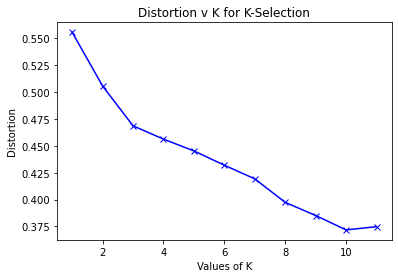

In [25]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,12)
grouped_clustering = grouped.drop(['City','Neighborhood'], axis=1)
print(grouped_clustering.shape)
for k in K: 
    #Building and fitting the model 
    kmeans = KMeans(n_clusters=k).fit(grouped_clustering) 
    kmeans.fit(grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(grouped_clustering, kmeans.cluster_centers_, 
                      'euclidean'),axis=1)) / grouped_clustering.shape[0]) 
    inertias.append(kmeans.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(grouped_clustering, kmeans.cluster_centers_, 
                 'euclidean'),axis=1)) / grouped_clustering.shape[0] 
    mapping2[k] = kmeans.inertia_ 
    
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Distortion v K for K-Selection') 
plt.show() 


In [26]:
# set number of clusters
kclusters = 8

grouped_clustering = grouped.drop(['City','Neighborhood'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 5], dtype=int32)

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [28]:
merged = pd.concat([df_stockholm, df_boston])
neighborhoods_venues_sorted['Cluster Labels'] = neighborhoods_venues_sorted['Cluster Labels'].astype(int)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index(['City','Neighborhood']), on=['City','Neighborhood'])

print(merged.shape)
#toronto_merged.head() # check the last columns!
merged = merged.dropna()
print(merged.shape)

merged

(104, 15)
(82, 15)


,City,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Stockholm, Sweden",Abrahamsberg,59.336468,17.953763,2.0,Intersection,Grocery Store,Metro Station,Bakery,Japanese Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run
1,"Stockholm, Sweden",Alvik,59.333401,17.982279,0.0,Gym / Fitness Center,Grocery Store,Light Rail Station,Café,Yoga Studio,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop
3,"Stockholm, Sweden",Aspudden,59.306466,18.001373,2.0,Pizza Place,Grocery Store,Metro Station,Bookstore,Bistro,Bakery,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
4,"Stockholm, Sweden",Axelsberg,59.304325,17.974414,2.0,Convenience Store,Metro Station,Grocery Store,Event Space,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Fried Chicken Joint
5,"Stockholm, Sweden",Bagarmossen,59.276186,18.131340,0.0,Pharmacy,Plaza,Fast Food Restaurant,Supermarket,Bakery,Creperie,Deli / Bodega,Department Store,Dessert Shop,Food Truck
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,"Somerville, MA",Ball Square,42.399911,-71.112274,0.0,Breakfast Spot,Coffee Shop,Diner,Bowling Alley,Furniture / Home Store,Sports Bar,Bakery,Vegetarian / Vegan Restaurant,Pet Store,Wine Shop
36,"Somerville, MA",Davis Square,42.396361,-71.122233,0.0,Café,Gift Shop,Hobby Shop,Soba Restaurant,Creperie,Pizza Place,Plaza,Poke Place,Ramen Restaurant,Burger Joint
37,"Somerville, MA",Magoun Square,42.394215,-71.106763,0.0,Dog Run,Yoga Studio,Fried Chicken Joint,Convenience Store,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop
39,"Somerville, MA",Powder House Square,42.401376,-71.116779,4.0,Mexican Restaurant,Plaza,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop,Yoga Studio


## Map the results

In [29]:
# create map
address = 'Stockholm, Sweden'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [30]:
# create map
address = 'Boston, MA'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
from IPython.display import display, HTML
for k in range(0,kclusters):
    print('Cluster # {:d}'.format(k))
    display(merged.loc[merged['Cluster Labels'] == k, merged.columns[[1] + list(range(5, merged.shape[1]))]].head())

Cluster # 0


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alvik,Gym / Fitness Center,Grocery Store,Light Rail Station,Café,Yoga Studio,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop
5,Bagarmossen,Pharmacy,Plaza,Fast Food Restaurant,Supermarket,Bakery,Creperie,Deli / Bodega,Department Store,Dessert Shop,Food Truck
21,Gamla stan,Café,Cocktail Bar,Plaza,Scandinavian Restaurant,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop,Dog Run,Diner
22,Gärdet,Pizza Place,Sushi Restaurant,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop,Yoga Studio
23,Gröndal,Pizza Place,Persian Restaurant,Light Rail Station,Bakery,Convenience Store,Playground,Creperie,Deli / Bodega,Department Store,Flea Market


Cluster # 1


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Blackeberg,Metro Station,Yoga Studio,Event Space,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Furniture / Home Store
13,Enskede gård,Metro Station,Yoga Studio,Event Space,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Furniture / Home Store
25,Hägersten,Metro Station,Yoga Studio,Event Space,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Furniture / Home Store
28,Hammarbyhöjden,Metro Station,Yoga Studio,Event Space,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Furniture / Home Store
67,Västertorp,Metro Station,Yoga Studio,Event Space,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Furniture / Home Store


Cluster # 2


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abrahamsberg,Intersection,Grocery Store,Metro Station,Bakery,Japanese Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run
3,Aspudden,Pizza Place,Grocery Store,Metro Station,Bookstore,Bistro,Bakery,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market
4,Axelsberg,Convenience Store,Metro Station,Grocery Store,Event Space,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Fried Chicken Joint
6,Bandhagen,Pizza Place,Grocery Store,Café,Mediterranean Restaurant,Sushi Restaurant,Metro Station,Hobby Shop,Historic Site,Fish Market,Convenience Store
8,Björkhagen,Metro Station,Trail,Yoga Studio,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Dog Run


Cluster # 3


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Lechmere Square,Bike Rental / Bike Share,Yoga Studio,Event Space,Food Truck,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Donut Shop,Furniture / Home Store


Cluster # 4


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Riddarholmen,Plaza,Monument / Landmark,Church,Yoga Studio,Donut Shop,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Diner
15,Louisburg Square,Plaza,Yoga Studio,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop,Diner
20,Pemberton Square,Coffee Shop,Plaza,Greek Restaurant,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Yoga Studio
39,Powder House Square,Mexican Restaurant,Plaza,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop,Yoga Studio


Cluster # 5


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Enskedefältet,Park,Yoga Studio,Fried Chicken Joint,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop
11,Franklin Square,Park,Yoga Studio,Fried Chicken Joint,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop
21,Post Office Square,Park,Yoga Studio,Fried Chicken Joint,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop


Cluster # 6


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Johanneshov,Hockey Arena,Yoga Studio,Dog Run,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop,Diner


Cluster # 7


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Långholmen,Scandinavian Restaurant,History Museum,Yoga Studio,Dog Run,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Donut Shop,Diner
41,Marieberg,Scandinavian Restaurant,Yoga Studio,Donut Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Event Space,Dog Run,Coffee Shop


In [32]:
merged = merged.set_index(['City','Neighborhood'])

## And figure out which neighborhoods in Stockholm are most like Davis Square!

In [34]:
DavisSquareCluster = merged.loc[('Somerville, MA','Davis Square'),'Cluster Labels']
print('The following neighborhoods are most similar to Davis Square:')
for hood in merged.loc[('Stockholm, Sweden')].query('`Cluster Labels` == 0').index:
    print(hood+', Stockholm, Sweden')

The following neighborhoods are most similar to Davis Square:
Alvik, Stockholm, Sweden
Bagarmossen, Stockholm, Sweden
Gamla stan, Stockholm, Sweden
Gärdet, Stockholm, Sweden
Gröndal, Stockholm, Sweden
Gubbängen, Stockholm, Sweden
Kärrtorp, Stockholm, Sweden
Kristineberg, Stockholm, Sweden
Liljeholmen, Stockholm, Sweden
Lilla Essingen, Stockholm, Sweden
Norrmalm, Stockholm, Sweden
Reimersholme, Stockholm, Sweden
Sätra, Stockholm, Sweden
Skeppsholmen, Stockholm, Sweden
Södermalm, Stockholm, Sweden
Stora Essingen, Stockholm, Sweden
Vasastan, Stockholm, Sweden
